# Fine-tuning Object Detection Model on a Custom Dataset, Deployment in Spaces, and Gradio API Integration

In this example, we will fine-tune an object detection model, specifically [DETR](https://huggingface.co/docs/transformers/model_doc/detr), using a custom dataset.

We start with a pretrained DETR model and fine-tune it on a custom dataset of annotated fashion images, namely [Fashionpedia](https://huggingface.co/datasets/detection-datasets/fashionpedia).

After successfully fine-tuning the model, we will deploy it as a Gradio Space on HuggingFace.

## Setups

In [ ]:
!pip install -U -q datasets transformers[torch] timm wandb torchmetrics matplotlib albumentations
# Tested with datasets==2.21.0, transformers==4.44.2 timm==1.0.9, wandb==0.17.9 torchmetrics==1.4.1

## Load dataset

The [Fashionpedia](https://huggingface.co/datasets/detection-datasets/fashionpedia) dataset includes
- 46,781 images
- 342,182 bounding boxes

In [ ]:
from datasets import load_dataset

dataset = load_dataset('detection-datasets/fashionpedia')

README.md:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

(…)-00000-of-00007-fe108070118553c3.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00001-of-00007-f41a5a9c38c9005b.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00002-of-00007-40bc8456894bcbcd.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00003-of-00007-9a99ff8dc572e02c.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00004-of-00007-f4e6f12cd2cedfea.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00005-of-00007-41d8dfe1edb6591e.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00006-of-00007-f41b0f2f4bbefac9.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00000-of-00001-0b29e85429788213.parquet:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 45623
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1158
    })
})

In [ ]:
dataset['train'][0]

{'image_id': 23,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x1024>,
 'width': 682,
 'height': 1024,
 'objects': {'bbox_id': [150311, 150312, 150313, 150314],
  'category': [23, 23, 33, 10],
  'bbox': [[445.0, 910.0, 505.0, 983.0],
   [239.0, 940.0, 284.0, 994.0],
   [298.0, 282.0, 386.0, 352.0],
   [210.0, 282.0, 448.0, 665.0]],
  'area': [1422, 843, 373, 56375]}}

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['val']

We may randomly sample 1% of the original dataset for both the training and test splits.

In [ ]:
def create_sample(dataset, sample_fraction=0.01, seed=111):
    sample_size = int(sample_fraction * len(dataset))
    sampled_dataset = dataset.shuffle(seed=seed).select(range(sample_size))
    print(f"Original dataset size: {len(dataset)}")
    print(f"Sampled dataset size: {len(sampled_dataset)}")
    return sampled_dataset


#train_dataset = create_sample(train_dataset)
#test_dataset = create_sample(test_dataset)

## Visualize one example from the dataset with its objects

### Generate id2label and label2id

In [ ]:
import numpy as np
from PIL import Image, ImageDraw

id2label = {
    0: "shirt, blouse",
    1: "top, t-shirt, sweatshirt",
    2: "sweater",
    3: "cardigan",
    4: "jacket",
    5: "vest",
    6: "pants",
    7: "shorts",
    8: "skirt",
    9: "coat",
    10: "dress",
    11: "jumpsuit",
    12: "cape",
    13: "glasses",
    14: "hat",
    15: "headband, head covering, hair accessory",
    16: "tie",
    17: "glove",
    18: "watch",
    19: "belt",
    20: "leg warmer",
    21: "tights, stockings",
    22: "sock",
    23: "shoe",
    24: "bag, wallet",
    25: "scarf",
    26: "umbrella",
    27: "hood",
    28: "collar",
    29: "lapel",
    30: "epaulette",
    31: "sleeve",
    32: "pocket",
    33: "neckline",
    34: "buckle",
    35: "zipper",
    36: "applique",
    37: "bead",
    38: "bow",
    39: "flower",
    40: "fringe",
    41: "ribbon",
    42: "rivet",
    43: "ruffle",
    44: "sequin",
    45: "tassel",
}


label2id = {v: k for k, v in id2label.items()}

### Draw one image

In [ ]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample['image']
    annotations = sample['objects']
    draw = ImageDraw.Draw(image)
    width, height = sample['width'], sample['height']

    print(annotations)

    for i in range(len(annotations['bbox_id'])):
        box = annotations['bbox'][i]
        x1, y1, x2, y2 = tuple(box)

        draw.rectangle((x1, y1, x2, y2), outline='red', width=3)
        draw.text(
            (x1, y1),
            id2label[annotations['category'][i]],
            fill='green'
        )

    return image

{'bbox_id': [158953, 158954, 158955, 158956, 158957, 158958, 158959, 158960, 158961, 158962], 'category': [2, 33, 31, 31, 13, 7, 22, 22, 23, 23], 'bbox': [[182.0, 220.0, 472.0, 647.0], [294.0, 221.0, 407.0, 257.0], [405.0, 297.0, 472.0, 647.0], [182.0, 264.0, 266.0, 621.0], [284.0, 135.0, 372.0, 169.0], [238.0, 537.0, 414.0, 606.0], [351.0, 732.0, 417.0, 922.0], [202.0, 749.0, 270.0, 930.0], [200.0, 921.0, 256.0, 979.0], [373.0, 903.0, 455.0, 966.0]], 'area': [87267, 1220, 16895, 18541, 1468, 9360, 8629, 8270, 2717, 3121]}


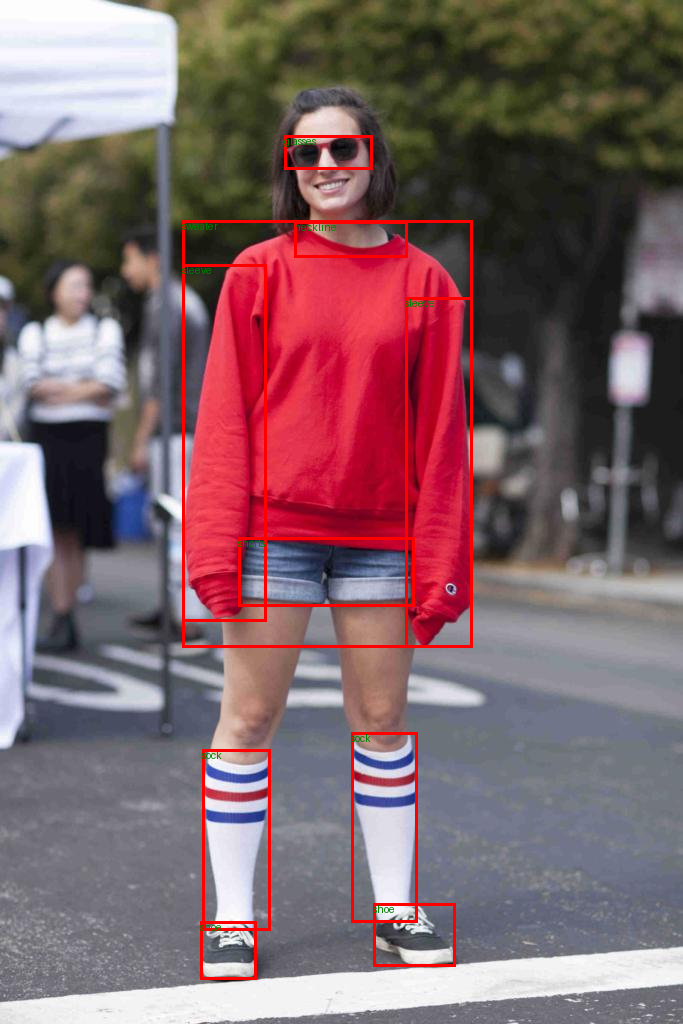

In [ ]:
draw_image_from_idx(dataset=train_dataset, idx=1)

### Visualize more images

In [ ]:
import matplotlib.pyplot as plt

def plot_images(dataset, indices):
    num_cols = 3
    num_rows = int(np.ceil(len(indices) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        image = draw_image_from_idx(dataset, idx)

        axes[row, col].imshow(image)
        axes[row, col].axis('off')

    # remove unused axes frame
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

{'bbox_id': [150311, 150312, 150313, 150314], 'category': [23, 23, 33, 10], 'bbox': [[445.0, 910.0, 505.0, 983.0], [239.0, 940.0, 284.0, 994.0], [298.0, 282.0, 386.0, 352.0], [210.0, 282.0, 448.0, 665.0]], 'area': [1422, 843, 373, 56375]}
{'bbox_id': [158953, 158954, 158955, 158956, 158957, 158958, 158959, 158960, 158961, 158962], 'category': [2, 33, 31, 31, 13, 7, 22, 22, 23, 23], 'bbox': [[182.0, 220.0, 472.0, 647.0], [294.0, 221.0, 407.0, 257.0], [405.0, 297.0, 472.0, 647.0], [182.0, 264.0, 266.0, 621.0], [284.0, 135.0, 372.0, 169.0], [238.0, 537.0, 414.0, 606.0], [351.0, 732.0, 417.0, 922.0], [202.0, 749.0, 270.0, 930.0], [200.0, 921.0, 256.0, 979.0], [373.0, 903.0, 455.0, 966.0]], 'area': [87267, 1220, 16895, 18541, 1468, 9360, 8629, 8270, 2717, 3121]}
{'bbox_id': [169196, 169197, 169198, 169199, 169200, 169201, 169202, 169203, 169204, 169205, 169206, 169207, 169208, 169209, 169210], 'category': [13, 29, 28, 32, 32, 31, 31, 0, 31, 31, 18, 4, 6, 23, 23], 'bbox': [[441.0, 132.0, 499

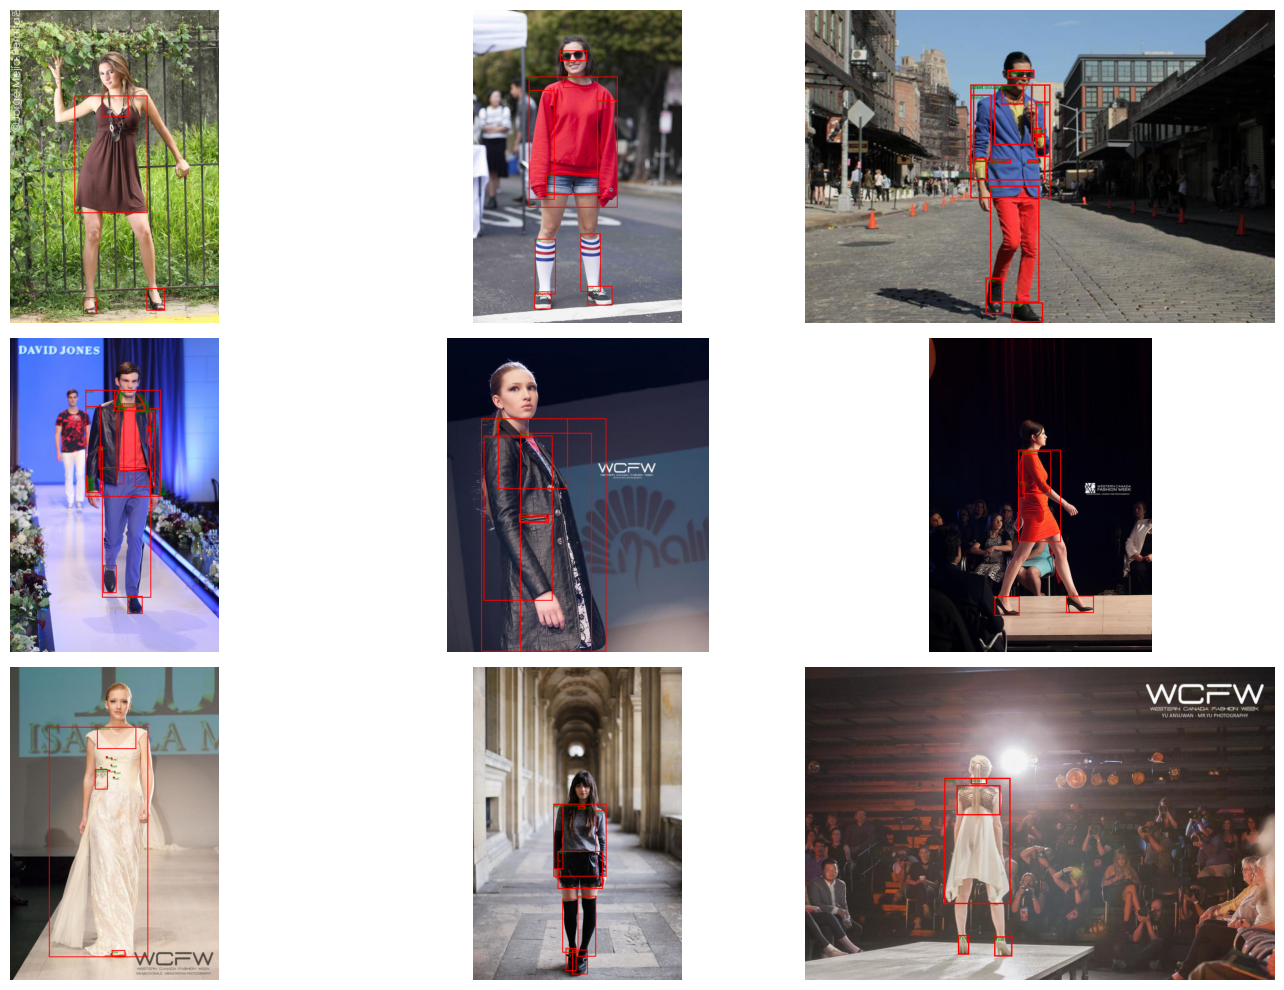

In [ ]:
plot_images(train_dataset, range(9))

## Filter invalid bounding boxes

Some bounding boxes did not have a valid structure, so we will discard these invalid entries.

In [ ]:
from datasets import Dataset

def filter_invalid_bboxes(example):
    valid_bboxes = []
    valid_bbox_ids = []
    valid_categories = []
    valid_area = []

    for i, bbox in enumerate(example['objects']['bbox']):
        x_min, y_min, x_max, y_max = bbox[:4]
        if x_min < x_max and y_min < y_max:
            valid_bboxes.append(bbox)
            valid_bbox_ids.append(example['objects']['bbox_id'][i])
            valid_categories.append(example['objects']['category'][i])
            valid_area.append(example['objects']['area'][i])
        else:
            print(f"Image with invalid bbox: {example['image_id']} Invalid bbox detected and discarded: {bbox} - bbox_id: {example['objects']['bbox_id'][i]} - category: {example['objects']['category'][i]}")

    example['objects']['bbox'] = valid_bboxes
    example['objects']['bbox_id'] = valid_bbox_ids
    example['objects']['category'] = valid_categories
    example['objects']['area'] = valid_area

    return example

In [ ]:
train_dataset = train_dataset.map(filter_invalid_bboxes)
test_dataset = test_dataset.map(filter_invalid_bboxes)

Map:   0%|          | 0/45623 [00:00<?, ? examples/s]

Image with invalid bbox: 8396 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 139952 - category: 42
Image with invalid bbox: 19725 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 23298 - category: 42
Image with invalid bbox: 19725 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 23299 - category: 42
Image with invalid bbox: 21696 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 277148 - category: 42
Image with invalid bbox: 23055 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 287029 - category: 33
Image with invalid bbox: 23671 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 290142 - category: 42
Image with invalid bbox: 26549 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 311943 - category: 37
Image with invalid bbox: 26834 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 309141 - category: 37
Image with invalid bbox: 31

Map:   0%|          | 0/1158 [00:00<?, ? examples/s]

## Visualize class occurrences

In [ ]:
id_list = []
category_examples = {}
for example in train_dataset:
    id_list += example['objects']['bbox_id']

    for category in example['objects']['category']:
        if id2label[category] not in category_examples:
            category_examples[id2label[category]] = 1
        else:
            category_examples[id2label[category]] += 1

id_list.sort()

<ipython-input-15-5f2395dcbe87>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=90, ha='right')


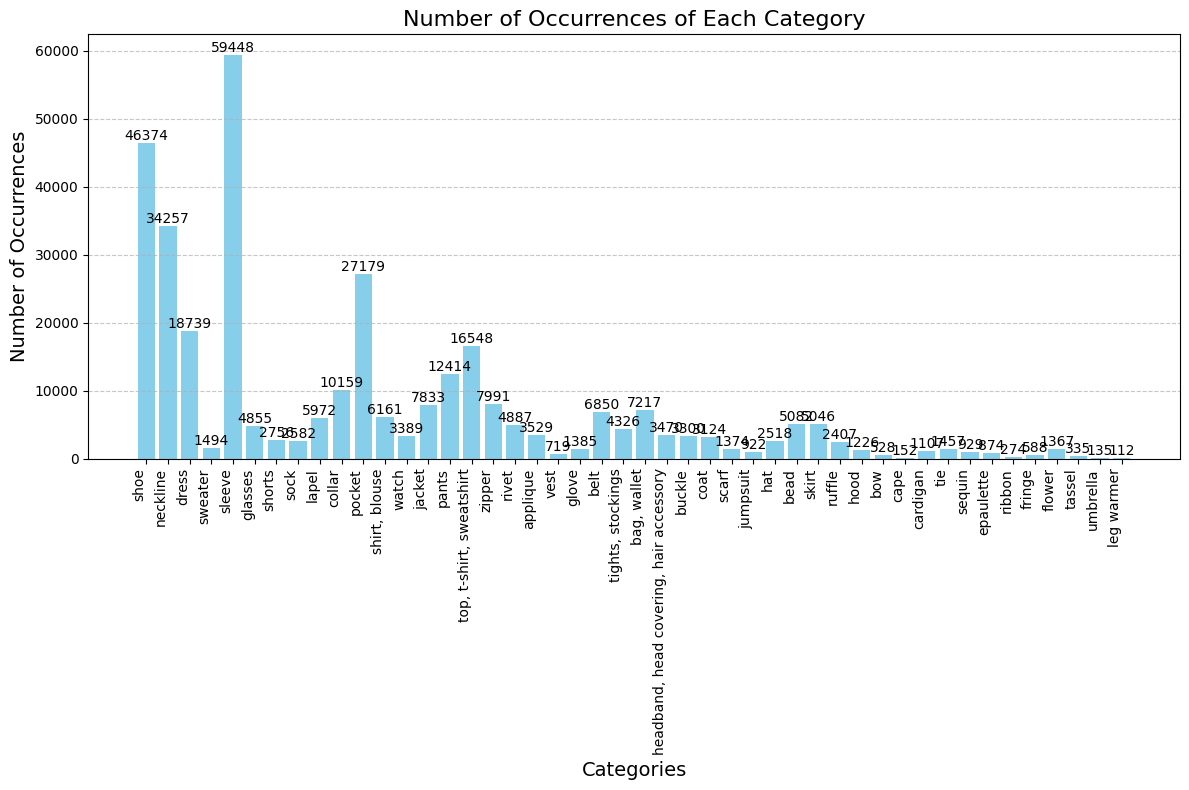

In [ ]:
categories = list(category_examples.keys())
values = list(category_examples.values())


fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(categories, values, color='skyblue')

ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Number of Occurrences', fontsize=14)
ax.set_title('Number of Occurrences of Each Category', fontsize=16)

ax.set_xticklabels(categories, rotation=90, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

This indicates that the dataset has an imbalance, with certain classes appearing more frequently than others. Identifying these imbalances is curcial for addressing potential biases in model training.

## Add data augmentation to the dataset

[`Albumentations`](https://albumentations.ai/) provides a range of powerful augmentation techniques tailored for object detection. It allows for various transformations, all while ensuring that bounding boxes are accurately adjusted. These capabilities help in generating a more diverse dataset, improving the model's robustness and generalization.

In [ ]:
import albumentations as A

train_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(min_height=500, min_width=500, border_mode=0, value=(0,0,0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category'])
)

val_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(min_height=500, min_width=500, border_mode=0, value=(0,0,0)),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category'])
)

<ipython-input-16-a0f462058c95>:6: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=500, min_width=500, border_mode=0, value=(0,0,0)),
<ipython-input-16-a0f462058c95>:21: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=500, min_width=500, border_mode=0, value=(0,0,0)),


## Initialize image processor from model checkpoint

We will instantiate the image processor using a pretrained model checkopint, the [`facebook/detr-resnet-50-dc5`](https://huggingface.co/facebook/detr-resnet-50-dc5) model.

In [ ]:
from transformers import AutoImageProcessor

checkpoint = 'facebook/detr-resnet-50-dc5'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


### Add methods to process the dataset

We will add methods to process the dataset. These methods will handle tasks such as transforming images and annotations to ensure they are compatible with the model.

In [ ]:
def formatted_annotations(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            'image_id': image_id,
            'category_id': category[i],
            'isCrowd': 0,
            'area': area[i],
            'bbox': list(bbox[i])
        }

        annotations.append(new_ann)

    return annotations


def convert_voc_to_coco(bbox):
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    return [x_min, y_min, width, height]


def transform_aug_annotations(examples, transform):
    image_ids = examples['image_id']
    images, bboxes, area, categories = [], [], [], []

    for image, objects in zip(examples['image'], examples['objects']):
        image = np.array(image.convert('RGB'))[:, :, ::-1]
        out = transform(
            image=image,
            bboxes=objects['bbox'],
            category=objects['category']
        )

        area.append(objects['area'])
        images.append(out['image'])

        # convert to COCO format
        converted_bboxes = [
            convert_voc_to_coco(bbox) for bbox in out['bboxes']
        ]
        bboxes.append(converted_bboxes)

        categories.append(out['category'])

    targets = [
        {'image_id': id_, 'annotations': format_annotations(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors='pt')



def transform_train(examples):
    return transform_aug_annotations(examples, train_transform)


def transform_val(examples):
    return transform_aug_annotations(examples, val_transform)

In [ ]:
train_dataset_transformed = train_dataset.with_transform(transform_train)
test_dataset_transformed = test_dataset.with_transform(transform_val)

## Plot augmented examples

In [ ]:
def draw_augmented_image_from_idx(dataset, idx, transform=None):
    sample = dataset[idx]
    image = sample['image']
    annotations = sample['objects']

    # convert image to RGB and numpy array
    image = np.array(image.convert("RGB"))[:, :, ::-1]

    if transform:
        augmented = transform(
            image=image,
            bboxes=annotations['bbox'],
            category=annotations['category']
        )
        image = augmented['image']
        annotations['bbox'] = augmented['bboxes']
        annotations['category'] = augmented['category']

    # convert back to PIL image
    image = Image.fromarray(image[:, :, ::-1])
    draw = ImageDraw.Draw(image)
    width, height = sample['width'], sample['height']

    for i in range(len(annotations['bbox_id'])):
        box = annotations['bbox'][i]
        x1, y1, x2, y2 = tuple(box)

        # normalize coordinates if necessary
        if max(box) <= 1.0:
            x1, y1 = int(x1 * width), int(y1 * height)
            x2, y2 = int(x2 * width), int(y2 * height)
        else:
            x1, y1 = int(x1), int(y1)
            x2, y2 = int(x2), int(y2)

        draw.rectangle((x1, y1, x2, y2), outline='red', width=3)
        draw.text((x1, y1), id2label[annotations['category'][i]], fill='green')

    return image


def plot_augmented_images(dataset, indices, transform=None):
    num_rows = len(indices) // 3
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw augmented image
        image = draw_augmented_image_from_idx(dataset, idx, transform=transform)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_augmented_images(train_dataset, range(9), transform=train_transform)

Output hidden; open in https://colab.research.google.com to view.

## Initialize model from checkpoint

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [ ]:
output_dir = "detr-resnet-50-dc5-fashionpedia-finetuned"

## Set training arguments, connect to W&B

In [ ]:
from transformers import TrainingArguments, Trainer
import torch

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=10000,
    fp16=True,
    save_steps=10,
    logging_steps=1,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    eval_strategy="steps",
    report_to='wandb',
    push_to_hub=True,
    batch_eval_metrics=True
)

In [ ]:
# connect to wandb
import wandb

wandb.init(
    project='detr-resnet-50-dc5-fashionpedia-finetuned',
    name='detr-resnet-50-dc5-fashionpedia-finetuned',
    config=training_args
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: binliu14qd (binliu14qd-nc-state-wolfpack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Train

We need to declare the `compute_metrics` to calculate the metrics on evaluation

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax

def denormalize_boxes(boxes, width, height):
    boxes = boxes.clone()
    boxes[:, 0] *= width # x_min
    boxes[:, 1] *= height # y_min
    boxes[:, 2] *= width # x_max
    boxes[:, 3] *= height # y_max

    return boxes


batch_metrics = []


def compute_metrics(eval_pred, compute_result):
    global batch_metrics

    pred_tuple, labels = eval_pred
    loss_dict, scores, pred_boxes, last_hidden_states, encoder_last_hidden_states = pred_tuple

    image_sizes = []
    target = []
    for label in labels:
        image_sizes.append(label['orig_size'])
        width, height = label['orig_size']
        denormalized_boxes = denormalize_boxes(label['boxes'], width, height)
        target.append({
            'boxes': denormalized_boxes,
            'labels': label['class_labels']
        })

    predictions = []
    for score, box, target_sizes in zip(scores, pred_boxes, image_sizes):
        # extract the bounding boxes, labels, and scores from the model's output
        pred_scores = score[:, :-1] # exclude the no-object class
        pred_scores = softmax(pred_scores, dim=-1)

        width, height = target_sizes
        pred_boxes = denormalize_boxes(box, width, height)
        pred_labels = torch.argmax(pred_scores, dim=-1)

        # get the scores corresponding to the predicted labels
        pred_scores_for_labels = torch.gather(pred_scores, 1, pred_labels.unsqueeze(-1)).squeeze(-1)
        predictions.append({
            'boxes': pred_boxes,
            'scores': pred_scores_for_labels,
            'labels': pred_labels
        })

    metric = MeanAveragePrecision(box_format='xywh', class_metrics=True)

    if not compute_result:
        # accumulate batch-level metrics
        batch_metrics.append({'preds': predictions, 'target': target})
        return {}
    else:
        # compute final aggregated metrics
        # aggregate batch-level metrics
        all_preds = []
        all_targets = []
        for batch in batch_metrics:
            all_preds.extend(batch['pred'])
            all_targets.extend(batch['target'])

        # update metric with all accumulated predictions and targets
        metric.update(preds=all_preds, target=all_targets)
        metrics = metric.compute()

        # convert and format metrics as needed
        classes = metrics.pop('classes')
        map_per_class = metrics.pop('map_per_class')
        mar_100_per_class = metrics.pop('mar_100_per_class')

        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        # round metrics for cleaner output
        metrics = {k: round(v.item(), 4) for k,v in metrics.items()}

        # clear batch metrics for next evaluation
        batch_metrics = []

        return metrics

In [ ]:
def collate_fn(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors='pt')
    labels = [item['labels'] for item in batch]

    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels

    return batch

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    processing_class=image_processor
)

In [ ]:
trainer.train()

## Test model performance on a test image

In [ ]:
import requests
from transformers import pipelines
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.unsplash.com/photo-1536243298747-ea8874136d64?q=80&w=640"

image = Image.open(requests.get(url, stream=True).raw)

obj_detector = pipeline(
    "object-detection",
    model="sergiopaniego/detr-resnet-50-dc5-fashionpedia-finetuned"
)

In [ ]:
results = obj_detector(image)
print(results)

In [ ]:
from PIL import Image, ImageDraw
import numpy as np


def plot_results(image, results, threshold=0.6):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    width, height = image.size

    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())

        if score > threshold:
            x1, y1, x2, y2 = tuple(box)
            draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
            draw.text((x1 + 5, y1 - 10), label, fill="white")
            draw.text((x1 + 5, y1 + 10), f"{score:.2f}", fill="green" if score > 0.7 else "red")

    return image

## Evaluate the model on a test set

In [ ]:
metrics = trainer.evaluate(test_dataset_transformed)
print(metrics)

## Deploy the model in a HuggingFace Space

Now that our model is available on HuggingFace, we can deploy it in a HuggingFace Space. HuggingFace provides free Spaces for small applications, allowing us to create an interactive web application where users can upload test images and evaluate the model's capabilities. Check an existing [demo](https://huggingface.co/spaces/sergiopaniego/DETR_object_detection_fashionpedia-finetuned).

In [ ]:
from IPython.display import IFrame

IFrame(
    src="https://sergiopaniego-detr-object-detection-fashionpedia-fa0081f.hf.space",
    width=1000,
    height=800
)

We can use `gradio` to create a new application and saved as `app.py`

In [ ]:
# app.py

import gradio as gr
import spaces
import torch

from PIL import Image
from transformers import pipeline
import matplotlib.pyplot as plt
import io

# load the model pipeline
model_pipeline = pipeline(
    "object-detection",
    model="sergiopaniego/detr-resnet-50-dc5-fashionpedia-finetuned"
)

COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933],
]


def get_output_figure(pil_img, results, threshold):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100

    for result in results:
        scores = result["score"]
        label = result["label"]
        box = list(result["box"].values())

        if scores > threshold:
            c = COLORS[hash(label) % len(COLORS)]
            ax.add_patch(
                plt.Rectangle(
                    (box[0], box[1]),
                    box[2] - box[0],
                    box[3] - box[1],
                    fill=False,
                    color=c,
                    linewidth=3
                )
            )
            text = f"{label}: {score:0.2f}"
            ax.text(
                box[0],
                box[1],
                text,
                fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5)
            )
    plt.axis('off')

    return plt.gcf()



@spaces.GPU
def detect(image):
    results = model_pipeline(image)
    print(results)

    output_figure = get_output_figure(image, results, threshold=0.7)

    buf = io.BytesIO()
    output_figure.savefig(buf, bbox_inches='tight')
    buf.seek(0)
    output_pil_img = Image.open(buf)

    return output_pil_img



with gr.Blocks as demo:
    gr.Markdown("# Object detection with DETR fine-tuned on detection-datasets/fashionpedia")
    gr.Markdown(
        """
        This application uses a fine tuned DETR (DEtection TRansformers) to detect objects on images.
        This version was trained using detection-datasets/fashionpedia dataset.
        You can load an image and see the predictions for the objects detected.
        """
    )

    gr.Interface(
        fn=detect,
        inputs=gr.Image(label='Input image', type='pil'),
        outputs=[gr.Image(label='Output prediction', type='pil')]
    )


demo.launch.(show_error=True)

We also need to create a `requirements.txt` file to specify the dependencies for the application.
```bash
!touch requirements.txt
!echo -e "transformers\ntimm\ntorch\ngradio\nmatplotlib" > requirements.txt
```

## Access the Space as an API

Once we set up a Space on HuggingFace, it provides an API that can be accessed from outside applications. This makes it easy to integrate the model into various applications, whether they are built with JavaScript, Python, or another language.

In [ ]:
!pip install -qU gradio_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 5.9 MB/s eta 0:00:00


In [ ]:
from gradio_client import Client, handle_file

client = Client("sergiopaniego/DETR_object_detection_fashionpedia-finetuned")

Loaded as API: https://sergiopaniego-detr-object-detection-fashionpedia-fa0081f.hf.space ✔


In [ ]:
client.view_api()

Client.predict() Usage Info
---------------------------
Named API endpoints: 1

 - predict(image, api_name="/predict") -> output_prediction
    Parameters:
     - [Image] image: filepath (required)  
    Returns:
     - [Image] output_prediction: filepath 



In [ ]:
# 1. Download the image to disk (must keep a real extension)
url = "https://images.unsplash.com/photo-1536243298747-ea8874136d64?q=80&w=640"
resp = requests.get(url, stream=True)
with open("photo.jpg", "wb") as f:
    for chunk in resp.iter_content(1024):
        f.write(chunk)

# 2. Now handle_file returns a proper FileData dict
result = client.predict(
    image=handle_file("photo.jpg"),
    api_name="/predict"
)

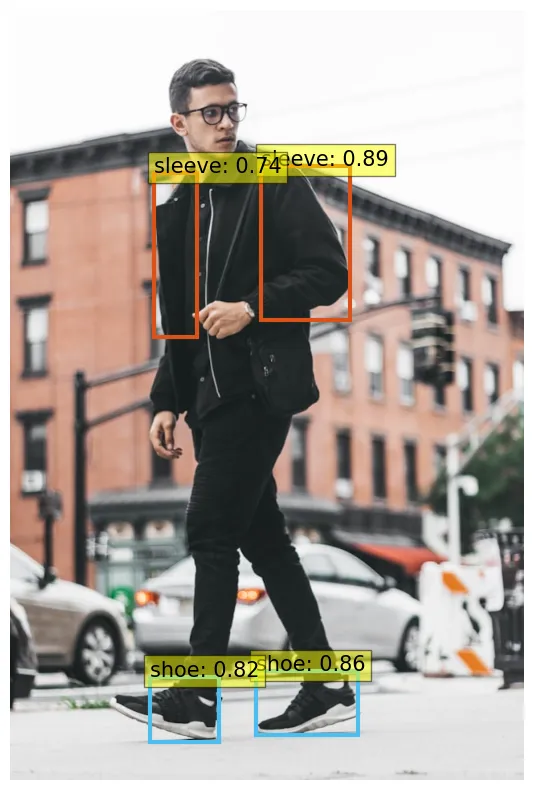

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open(result).convert("RGB")
display(img)